# Starbucks Capstone Project

### Introduction
The aim of sale promotions by companies on its products and services is to increase sales, attract new customers, encourage loyalty, and repeat purchases. These promotions usually have a lifespan and they are integrated accross various marketing channels. Inorder to run an effective and productive sales promotion, the company needs to collect and study its customers behaviour in relation to its product and services.

The customers wants to feel that the company truly undertands  them. The most important thing that makes a sales promotion productive is selecting the right target audience. By pretermining a target audience, companies can put their promotions to efficient use. This project aims to use Machine Learning to help Starbucks determine which demography of its customers will respond best to a certain type of promotion.


### Data
The dataset for this project contains simulated data that mimics customer behaviour on the Starbucks mobile reward app. This dataset is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products. 

Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

The dataset contains transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

The data is contained in three files:
1. **profile**.json: Contains demographic data for each customer. It is made up of 17,000 customers with 5 fields.
    * gender: (categorical) M, F, O, or null.
    * age: (numeric) missing value encoded as 118.
    * id: (string/hash).
    * became_member_on: (date) format:YYYYMMDD.
    * income: (numeric).
2. **portfolio.json**: Contains data on offers sent during 30-day test period. It is made up of 10 offers with 6 fields.
    * reward: (numeric) money awarded for the amount spent.
    * channels: (list) web, email, mobile, social.
    * difficulty: (numeric) money required to be spent to receive reward.
    * duration: (numeric) time for offer to be open, in days.
    * offer_type: (string) bogo, discount, informational.
    * id: (string/hash).
3. **transcript.json**: Contains records for customer transactions, offers received, offers viewed, and offers completed. It is made up of 306648 transactions with 4 fields.
    * person: (string/hash).
    * event: (string) offer received, offer.
    * value: (dictionary) different values depending on event type:
        * offer id: (string/hash) not associated with any "transaction".
        * amount: (numeric) money spent in "transaction".
        * reward: (numeric) money gained from "offer completed".
    * time: (numeric) hours after start of test.

In [ ]:
# Install dependencies

!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

## Exploratory data analysis

The next stage of project data collection, visualization, preprocessing, and transformation.

### Data Collection

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import matplotlib.pyplot as plt

In [5]:
# read data from the json files into pandas dataframes
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Analysis and Cleaning

#### 1. Portfolio dataframe
Contains information about types of offers sent during a 30-days period

In [6]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [20]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


##### Portfolio dataframe cleaning

There are 10 rows of data and there are no null values in portfolio dataframe. 

Next steps:
1. Convert the categorical columns values in portfolio dataframe to numerical values using one hot encoding.
2. Change the name of the 'id' column to 'offer_id'.
3. Drop original categorical columns.

In [7]:
# One hot encoding 
portfolio = portfolio.join(portfolio.channels.str.join('|').str.get_dummies())
portfolio = portfolio.join(portfolio.offer_type.str.get_dummies())
# Change 'id' and 'reward' column name
portfolio = portfolio.rename(columns = {'id': 'offer_id'})
portfolio = portfolio.rename(columns = {'reward': 'offer_reward'})
# Drop original categorical columns
portfolio.drop(['channels', 'offer_type'],axis=1,inplace=True)
portfolio

,offer_reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [8]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   offer_reward   10 non-null     int64 
 1   difficulty     10 non-null     int64 
 2   duration       10 non-null     int64 
 3   offer_id       10 non-null     object
 4   email          10 non-null     int64 
 5   mobile         10 non-null     int64 
 6   social         10 non-null     int64 
 7   web            10 non-null     int64 
 8   bogo           10 non-null     int64 
 9   discount       10 non-null     int64 
 10  informational  10 non-null     int64 
dtypes: int64(10), object(1)
memory usage: 1008.0+ bytes


#### 2. Profile dataframe
Contains information demographic information about customers

In [9]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [11]:
# Check for null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There are 17,000 rows in profile dataframe. Two columns in this dataframe contain 2,175 null values each, the columns are 'gender' and 'became_member_on' columns. Lets view these rows with null values. Lets view what these rows with null values look like.


Text(0, 0.5, '')

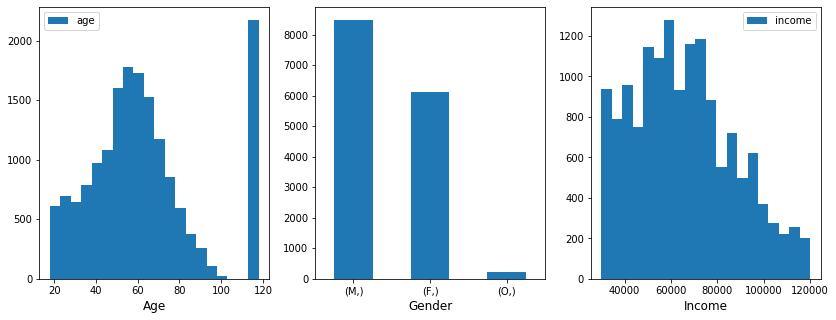

In [14]:
# profile data analysis

fig, ax = plt.subplots(1, 3, figsize=(14,5))

profile[['age']].plot(ax = ax[0],kind='hist', bins=20)
profile[['gender']].value_counts().plot(ax = ax[1], kind='bar', stacked=True, rot=0)
profile[['income']].plot(ax = ax[2], kind='hist', bins=20)

ax[0].set_xlabel('Age', fontsize=12)
ax[0].set_ylabel(None)
ax[1].set_xlabel('Gender', fontsize=12)
ax[1].set_ylabel(None)
ax[2].set_xlabel('Income', fontsize=12)
ax[2].set_ylabel(None)

We can observe from the 'age' distribution that there is an outlier and that is from the maximum value in the age distribution. Let's view what this maximum age value is.

In [15]:
profile['age'].max()

118

In [16]:
# The outlier in 'age' distribution has a value of 118. Let's view rows where the value of age is 118.

profile[profile['age'] == 118]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


##### Profile dataframe cleaning

Next steps:
1. It is observed that 'gender' column is null and 'income' column contain null values where 'age' is 118. In other words, the null values appear in both the columns for same rows. Its is advisable to drop these rows.
2. Change the name of the 'id' column to 'customer_id'.

In [17]:
# Drop rows where 'age' is 118
profile = profile[profile.age != 118]
# Change 'id' column name
profile = profile.rename(columns = {'id': 'customer_id'})
profile

,gender,age,customer_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


Text(0.5, 1.0, 'Gender-wise age distribution')

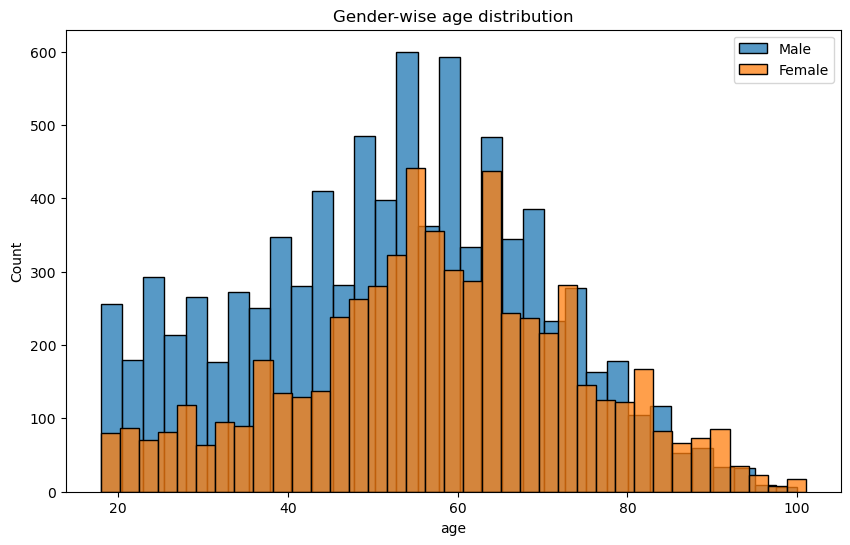

In [49]:
# Gender-wise age distribution
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(x=profile[profile.gender == 'M'].age, label='Male',ax=ax)
sns.histplot(x=profile[profile.gender == 'F'].age, label='Female',ax=ax)
ax.legend()
ax.set_title('Gender-wise age distribution')



Text(0.5, 1.0, 'Gender-wise income distribution')

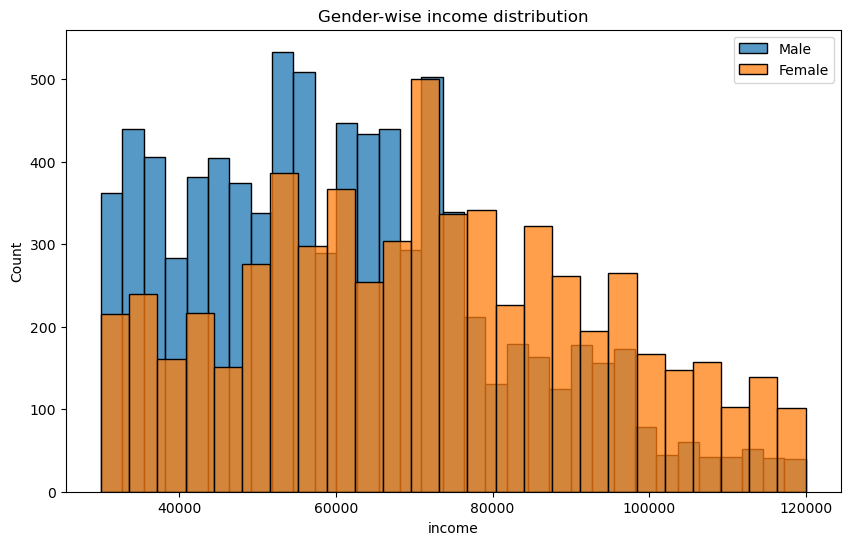

In [51]:
# Gender-wise income distribution
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(x=profile[profile.gender=='M'].income, label='Male', ax=ax)
sns.histplot(x=profile[profile.gender=='F'].income, label='Female', ax=ax)
ax.legend()
ax.set_title('Gender-wise income distribution')

#### 3. Transcript dataframe
Contains records for customer transactions, offers received, offers viewed, and offers completed

In [18]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [19]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [20]:
#Check for null
transcript.columns.duplicated().sum()

0

There are no null values in transcript dataframe. Lets analyze the dataframe.

In [21]:
#Event types
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

From the statistics above we can see that 76,277 offers were received by the customers. 57,725 of these offers were viewed by customers and only 33,579 of these offers were completed by customers. There were 138,953 transactions during the period the offers were sent out.

In [22]:
offer_received = transcript[transcript.event == 'offer received']
offer_received.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [23]:
offer_viewed = transcript[transcript.event == 'offer viewed']
offer_viewed.head()

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [24]:
offer_completed = transcript[transcript.event == 'offer completed']
offer_completed.head()

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


In [25]:
transaction = transcript[transcript.event == 'transaction']
transaction.head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


I think 'transaction' data does not give any useful information on offers, it will be removed.

##### Transcript dataframe cleaning

Next steps:
1. Change the name of the 'person' column to 'customer_id'.
2. Extract offer id, reward from 'value' column.
3. Drop 'value' column.
4. Remove rows where 'event' column contain 'transaction'.


In [26]:

# Change 'person' column name
transcript = transcript.rename(columns = {'person': 'customer_id'})
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [27]:
# Extract offer id, reward from 'value' column
temp = pd.json_normalize(transcript['value'])
temp

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...
306529,NaN,1.59,NaN,NaN
306530,NaN,9.53,NaN,NaN
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN


In [28]:
# Replace the null values with space
temp['offer_id'].fillna("", inplace = True)
temp['offer id'].fillna("", inplace = True)

# Combine the offer_id and offer id columns
temp['offer_id'] = temp['offer id'] + temp['offer_id']

# Replace the null values with 0
temp['reward'].fillna(0, inplace = True)

# Drop offer id columns
temp.drop(columns = ['offer id', 'amount'], inplace = True)
temp

,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,2906b810c7d4411798c6938adc9daaa5,0.0
3,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0
...,...,...
306529,,0.0
306530,,0.0
306531,,0.0
306532,,0.0


In [29]:
# Add the 'temp' columns to the original 'transcript' dataframe
transcript = pd.concat([transcript,temp], axis = 1)
transcript.drop(columns = ['value'], inplace = True)
transcript.rename(columns = {'reward': 'reward_received'}, inplace = True)
transcript

,customer_id,event,time,offer_id,reward_received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,,0.0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,,0.0
306531,a00058cf10334a308c68e7631c529907,transaction,714,,0.0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,,0.0


In [30]:
# Remove transaction data from transcript dataframe
transcript = transcript[transcript.event != 'transaction']
transcript

,customer_id,event,time,offer_id,reward_received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,2.0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,2.0


#### Merge dataframes

In [31]:
# Merge profile, transcript and portfolio dataframes.
df = pd.merge(profile, transcript, on='customer_id')
df = pd.merge(df, portfolio, on='offer_id')
df.head()

,gender,age,customer_id,became_member_on,income,event,time,offer_id,reward_received,offer_reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,5,7,1,1,0,1,1,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer completed,528,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5,5,7,1,1,0,1,1,0,0
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,5,7,1,1,0,1,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,5,7,1,1,0,1,1,0,0
4,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5,5,7,1,1,0,1,1,0,0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   gender            148805 non-null  object 
 1   age               148805 non-null  int64  
 2   customer_id       148805 non-null  object 
 3   became_member_on  148805 non-null  int64  
 4   income            148805 non-null  float64
 5   event             148805 non-null  object 
 6   time              148805 non-null  int64  
 7   offer_id          148805 non-null  object 
 8   reward_received   148805 non-null  float64
 9   offer_reward      148805 non-null  int64  
 10  difficulty        148805 non-null  int64  
 11  duration          148805 non-null  int64  
 12  email             148805 non-null  int64  
 13  mobile            148805 non-null  int64  
 14  social            148805 non-null  int64  
 15  web               148805 non-null  int64  
 16  bogo              14

### Data Preprocessing

Data preprocessing, Feature Engineering, and Hyperparameter Tuning  will be done by AutoGluon automatically. Let's create the target column.
What makes a promotion successful? In my opinion, when offers are completed, that makes the promotion a successful. The target column will state whether the offer was successful (1) or not (0).


In [33]:

df['gender']=df['gender'].astype('category')
df['event']=df['event'].astype('category')
df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')

df['target'] = [0 if x == 0 else 1 for x in df['reward_received']]
df.head()

,gender,age,customer_id,became_member_on,income,event,time,offer_id,reward_received,offer_reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,target
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,5,7,1,1,0,1,1,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,offer completed,528,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5,5,7,1,1,0,1,1,0,0,1
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,5,7,1,1,0,1,1,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,5,7,1,1,0,1,1,0,0,0
4,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5,5,7,1,1,0,1,1,0,0,1


In [72]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

In [67]:
training_data.drop(columns = ['reward_received','customer_id'], inplace = True)
training_data.head()

,gender,age,became_member_on,income,event,time,offer_id,offer_reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,target
117706,M,75,2017-07-26,68000.0,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,1,1,1,1,0,1,0,0
108906,M,72,2017-09-29,61000.0,offer viewed,222,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,1,1,1,1,0,1,0,0
129423,M,55,2017-04-25,35000.0,offer completed,552,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,0,1,0,1,0,1
143381,F,88,2016-11-26,32000.0,offer viewed,504,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0,0
72574,F,70,2017-06-21,87000.0,offer viewed,222,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,0,1,0,1,0,0


In [73]:
testing_data.drop(columns = ['reward_received','customer_id'], inplace = True)
testing_data.head()

,gender,age,became_member_on,income,event,time,offer_id,offer_reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,target
89141,M,48,2016-08-01,32000.0,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,1,1,1,1,0,1,0,0
120894,M,30,2018-03-05,35000.0,offer viewed,258,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,0,1,0,1,0,0
121295,M,57,2017-12-15,69000.0,offer received,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,0,1,0,1,0,0
147352,F,64,2015-10-16,73000.0,offer viewed,348,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0,0
12162,M,59,2016-01-04,58000.0,offer received,336,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0,0


In [70]:
from autogluon.tabular import TabularDataset, TabularPredictor

predictor= TabularPredictor(label ='target').fit(train_data = training_data, verbosity = 2,presets='best_quality', time_limit=1200)


No path specified. Models will be saved in: "AutogluonModels/ag-20230413_110240/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "AutogluonModels/ag-20230413_110240/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Mar 14 23:44:59 UTC 2023
Train Data Rows:    119044
Train Data Columns: 17
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Gene

In [71]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

AutoGluon infers problem type is:  binary
AutoGluon identified the following types of features:
('category', [])             : 3 | ['gender', 'event', 'offer_id']
('float', [])                : 1 | ['income']
('int', [])                  : 5 | ['age', 'time', 'offer_reward', 'difficulty', 'duration']
('int', ['bool'])            : 6 | ['mobile', 'social', 'web', 'bogo', 'discount', ...]
('int', ['datetime_as_int']) : 5 | ['became_member_on', 'became_member_on.year', 'became_member_on.month', 'became_member_on.day', 'became_member_on.dayofweek']


In [57]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           LightGBM_BAG_L1   1.000000       0.151284   21.664018                0.151284          21.664018            1       True          4
1           CatBoost_BAG_L1   1.000000       0.157123   42.202772                0.157123          42.202772            1       True          7
2      LightGBMLarge_BAG_L1   1.000000       0.163639   22.414208                0.163639          22.414208            1       True         12
3         LightGBMXT_BAG_L1   1.000000       0.196853   22.223552                0.196853          22.223552            1       True          3
4            XGBoost_BAG_L1   1.000000       0.589409   22.369272                0.589409          22.369272            1       True         11
5   RandomForestGini_BAG_L1   1.000000       2.709718   11.048468         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': 0.7411461308423776,
  'KNeighborsDist_BAG_L1': 0.6889385437317295,
  'LightGBMXT_BAG_L1': 1.0,
  'LightGBM_BAG_L1': 1.0,
  'RandomForestGini_BAG_L1': 1.0,
  'RandomForestEntr_BAG_L1': 1.0,
  'CatBoost_BAG_L1': 1.0,
  'ExtraTrees

In [58]:
predictor.feature_importance(data=training_data)

These features in provided data are not utilized by the predictor and will be ignored: ['email']
Computing feature importance via permutation shuffling for 17 features using 5000 rows with 5 shuffle sets...
	49.71s	= Expected runtime (9.94s per shuffle set)
	10.0s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
event,0.16488,0.005131,1.124388e-07,5,0.175446,0.154314
reward_received,0.11924,0.008290,2.785909e-06,5,0.136310,0.102170
gender,0.00000,0.000000,5.000000e-01,5,0.000000,0.000000
duration,0.00000,0.000000,5.000000e-01,5,0.000000,0.000000
discount,0.00000,0.000000,5.000000e-01,5,0.000000,0.000000
bogo,0.00000,0.000000,5.000000e-01,5,0.000000,0.000000
web,0.00000,0.000000,5.000000e-01,5,0.000000,0.000000
social,0.00000,0.000000,5.000000e-01,5,0.000000,0.000000
mobile,0.00000,0.000000,5.000000e-01,5,0.000000,0.000000
offer_reward,0.00000,0.000000,5.000000e-01,5,0.000000,0.000000


In [74]:
test_data=testing_data.drop(['target'],axis=1)
y_pred = predictor.predict(test_data)

In [75]:
predictor.evaluate(testing_data)

Evaluation: accuracy on test data: 1.0
Evaluations on test data:
{
    "accuracy": 1.0,
    "balanced_accuracy": 1.0,
    "mcc": 1.0,
    "roc_auc": 1.0,
    "f1": 1.0,
    "precision": 1.0,
    "recall": 1.0
}


{'accuracy': 1.0,
 'balanced_accuracy': 1.0,
 'mcc': 1.0,
 'roc_auc': 1.0,
 'f1': 1.0,
 'precision': 1.0,
 'recall': 1.0}